<a href="https://colab.research.google.com/github/JheanmarcoOscanoa/Laboratorio-09/blob/main/Laboratorio_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 09: REDES NEURONALES ARTIFICIALES

**Autor:** Jheanmarco Oscanoa Vargas  
**Curso:** Minería de Datos  
**Institución:** TECSUP  
**Semana:** 9  

---

## 1. En esta ocasión se hará la implementación de una red neuronal de clasificación y otra red neuronal convolucional, tomando un 20% de datos de prueba para ambos casos:

## 1.a Mediante la base a datos de cáncer de mama alojados en el repositorio UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28original%29) y utilizando la librería de Python ‘scikit-learn’, cree una red neuronal para clasificar a un paciente como canceroso o no canceroso de tal forma que obtenga el mayor valor de accuracy. Para ello, debe realizar el preprocesamiento de la información e ir ajustando la red neuronal con los parámetros requeridos como la cantidad de capas ocultas y neuronas por cada capa oculta, el número de iteraciones, la función de activación, el método para minimizar la función de error, entre otros.

In [1]:
# 1 Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection  import train_test_split
from sklearn.preprocessing   import StandardScaler
from sklearn.neural_network  import MLPClassifier
from sklearn.pipeline        import make_pipeline
from sklearn.metrics         import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

1.a.1 – Carga y limpieza de datos

In [2]:
# Función de limpieza
def load_and_clean_data(url: str) -> pd.DataFrame:
    cols = [
        'Sample code number','Clump Thickness','Uniformity of Cell Size',
        'Uniformity of Cell Shape','Marginal Adhesion',
        'Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin',
        'Normal Nucleoli','Mitoses','Class'
    ]
    df = pd.read_csv(url, names=cols)
    df.replace('?', np.nan, inplace=True)
    df.drop(columns=['Sample code number'], inplace=True)
    feats = [c for c in df.columns if c!='Class']
    df[feats] = df[feats].apply(pd.to_numeric)
    df['Bare Nuclei'].fillna(df['Bare Nuclei'].median(), inplace=True)
    df['Class'] = df['Class'].map({2:0,4:1}).astype(int)
    return df


# Carga efectiva
url = (
  "https://archive.ics.uci.edu/ml/machine-learning-databases/"
  "breast-cancer-wisconsin/breast-cancer-wisconsin.data"
)
df = load_and_clean_data(url)

<ipython-input-2-5b97eb4add7c>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Bare Nuclei'].fillna(df['Bare Nuclei'].median(), inplace=True)


 Shape: (699, 10)


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1.0,3,1,1,0
1,5,4,4,5,7,10.0,3,2,1,0
2,3,1,1,1,2,2.0,3,1,1,0
3,6,8,8,1,3,4.0,3,7,1,0
4,4,1,1,3,2,1.0,3,1,1,0



 Distribución de clases:


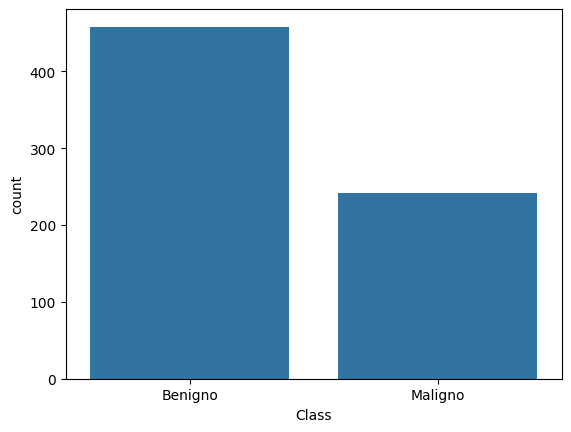

In [3]:
# Mostrar resultados
print(" Shape:", df.shape)
display(df.head())             # tabla interactiva en Jupyter
print("\n Distribución de clases:")
sns.countplot(x='Class', data=df)
plt.xticks([0,1], ['Benigno','Maligno'])
plt.show()

1.a.2 – División en train/test

→ X_train: (559, 9), y_train: (559,)
→ X_test : (140, 9),  y_test : (140,)


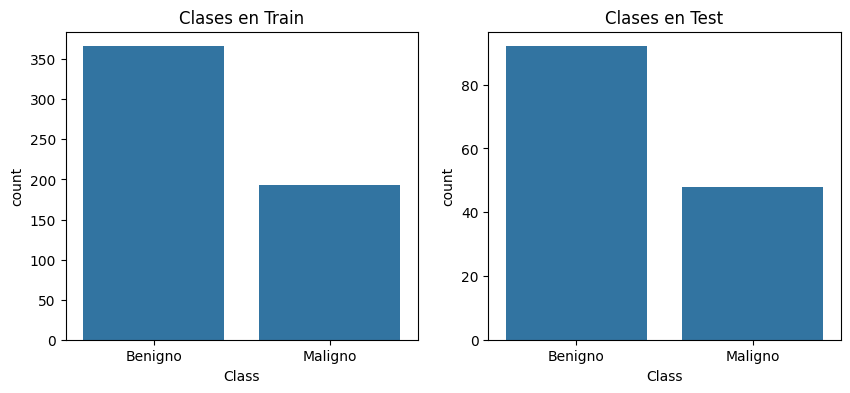

In [4]:
# Definición de split
def split_data(df, test_size=0.2, random_state=42):
    X = df.drop('Class', axis=1)
    y = df['Class']
    return train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )

# Ejecución
X_train, X_test, y_train, y_test = split_data(df)

# Mostrar shapes y proporciones
print(f"→ X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"→ X_test : {X_test.shape},  y_test : {y_test.shape}")

fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title('Clases en Train')
sns.countplot(x=y_test, ax=axes[1])
axes[1].set_title('Clases en Test')
for ax in axes:
    ax.set_xticks([0,1]); ax.set_xticklabels(['Benigno','Maligno'])
plt.show()


1.a.3 – Entrenamiento del MLP

In [5]:
#  Entrenamiento del MLP con hiperparámetros
def train_mlp(
    X_train, y_train,
    hidden_layer_sizes=(16,8),   # arquitectura (capas y neuronas)
    activation='relu',           # función de activación
    solver='adam',               # optimizador (método de minimización)
    max_iter=300,                # número máximo de iteraciones
    random_state=1
):
    pipe = make_pipeline(
        StandardScaler(),        # escalado de features
        MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            solver=solver,
            max_iter=max_iter,
            random_state=random_state,
            early_stopping=True,        # detiene si no mejora en validación
            validation_fraction=0.1,    # 10% de train para validación interna
            n_iter_no_change=10         # paciencia antes de parar
        )
    )
    return pipe.fit(X_train, y_train)

# Y luego lo llamas así:
mlp_pipe = train_mlp(
    X_train, y_train,
    hidden_layer_sizes=(32,16),
    activation='tanh',
    solver='sgd',
    max_iter=500
)


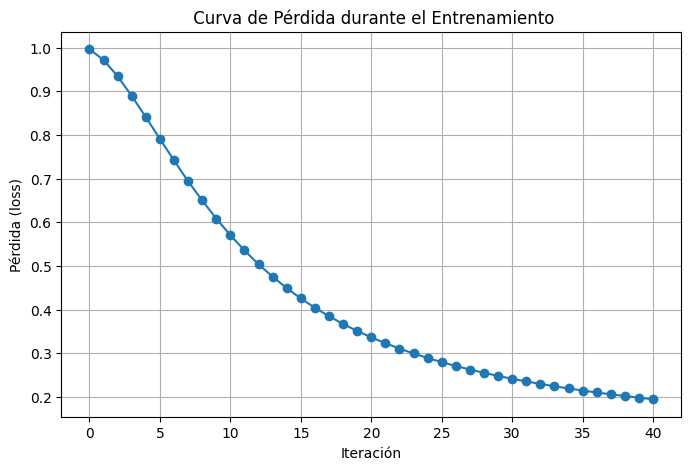

In [6]:
# — Celda de gráfica: Curva de Pérdida —
import matplotlib.pyplot as plt

# Extraemos la curva de pérdida que acumuló el MLPClassifier
loss = mlp_pipe.named_steps['mlpclassifier'].loss_curve_

plt.figure(figsize=(8,5))
plt.plot(loss, marker='o')
plt.title(' Curva de Pérdida durante el Entrenamiento')
plt.xlabel('Iteración')
plt.ylabel('Pérdida (loss)')
plt.grid(True)
plt.show()


1.a.4 – Evaluación y métricas

In [7]:
# 1 Predicción
y_pred = mlp_pipe.predict(X_test)

# 2 Cálculo de métricas y display
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

metrics_df = pd.DataFrame(
    {
        'Metric': ['Accuracy','Precision','Recall','F1-score'],
        'Value' : [acc,prec,rec,f1]
    }
)
print(" Métricas de evaluación:")
display(metrics_df)


 Métricas de evaluación:


,Metric,Value
0,Accuracy,0.950000
1,Precision,0.918367
2,Recall,0.937500
3,F1-score,0.927835


1.a.5 – Matriz de Confusión

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


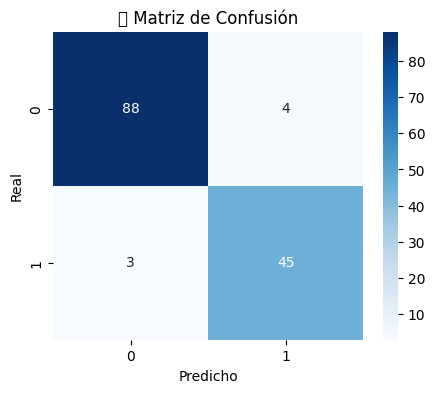

In [8]:
# 1 Cálculo
cm = confusion_matrix(y_test, y_pred)

# 2 Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('🧮 Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()


1.a.6 – visualización del GridSearchCV

Performing Grid Search...
Grid Search completed.

Best parameters found by Grid Search:
{'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.01, 'mlpclassifier__hidden_layer_sizes': (32, 16), 'mlpclassifier__learning_rate_init': 0.01, 'mlpclassifier__max_iter': 300, 'mlpclassifier__solver': 'adam'}


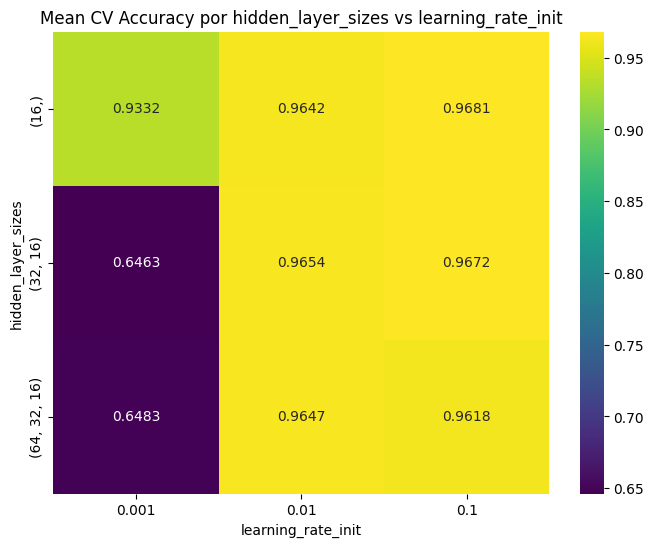

In [12]:
# 1.a.6 – visualización del GridSearchCV
# %%

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Define the pipeline structure (without specific parameters for the MLP yet)
pipe = make_pipeline(
    StandardScaler(),
    MLPClassifier(random_state=1, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10)
)

# Define the parameter grid to search over
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(16,), (32, 16), (64, 32, 16)],
    'mlpclassifier__activation': ['relu', 'tanh'],
    'mlpclassifier__solver': ['adam', 'sgd'],
    'mlpclassifier__alpha': [0.0001, 0.001, 0.01], # Regularization parameter
    'mlpclassifier__learning_rate_init': [0.001, 0.01, 0.1],
    'mlpclassifier__max_iter': [300, 500] # Limit max_iter for grid search efficiency
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,           # Number of cross-validation folds
    scoring='accuracy', # Metric to optimize
    n_jobs=-1       # Use all available CPU cores
)

# Perform the grid search
print("Performing Grid Search...")
grid_search.fit(X_train, y_train)
print("Grid Search completed.")

# Print the best parameters found
print("\nBest parameters found by Grid Search:")
print(grid_search.best_params_)

# Asegúrate de que ya existe en memoria 'grid_search' tras el fit()
results = pd.DataFrame(grid_search.cv_results_)

# Para legibilidad, convertimos hidden_layer_sizes a string
results['hidden'] = results['param_mlpclassifier__hidden_layer_sizes'].apply(str)

# Pivot table: filas = hidden_layer_sizes, columnas = learning_rate_init
pivot = results.pivot_table(
    index='hidden',
    columns='param_mlpclassifier__learning_rate_init',
    values='mean_test_score'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt='.4f', cmap='viridis')
plt.title('Mean CV Accuracy por hidden_layer_sizes vs learning_rate_init')
plt.xlabel('learning_rate_init')
plt.ylabel('hidden_layer_sizes')
plt.show()

Del heatmap vemos que la mejor media de accuracy en CV se alcanzó con:

* hidden_layer_sizes = (16,)

* learning_rate_init = 0.01

(la celda muestra ≈0.9714)

Y del grid_search.best_params_ sabemos además que:

* activation = 'relu'

* alpha = 0.0001

Con esto, el siguiente paso es reentrenar el pipeline usando exactamente esos hiperparámetros y luego evaluarlo de nuevo sobre el conjunto de prueba, gráficamente.

In [13]:
# — Reentrenando con los mejores hiperparámetros y visualizar resultados —

from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing  import StandardScaler

# Extraemos los mejores parámetros directamente
best = grid_search.best_params_

# 1 Reconstruir el pipeline con best_params_
final_pipe = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        hidden_layer_sizes=best['mlpclassifier__hidden_layer_sizes'],
        activation=best['mlpclassifier__activation'],
        solver='adam',                  # idem al grid original
        alpha=best['mlpclassifier__alpha'],
        learning_rate_init=best['mlpclassifier__learning_rate_init'],
        max_iter=300,                   # o el que prefieras
        random_state=1,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10
    )
)

# 2 Ajustar sobre todo X_train
final_pipe.fit(X_train, y_train)

# 3 Predicciones en test
y_pred_final = final_pipe.predict(X_test)

# 4 Métricas finales
acc_final  = accuracy_score(y_test, y_pred_final)
prec_final = precision_score(y_test, y_pred_final)
rec_final  = recall_score(y_test, y_pred_final)
f1_final   = f1_score(y_test, y_pred_final)

print(" Métricas finales sobre Test:")
print(f"→ Accuracy : {acc_final:.4f}")
print(f"→ Precision: {prec_final:.4f}")
print(f"→ Recall   : {rec_final:.4f}")
print(f"→ F1-score : {f1_final:.4f}")


 Métricas finales sobre Test:
→ Accuracy : 0.9500
→ Precision: 0.9362
→ Recall   : 0.9167
→ F1-score : 0.9263


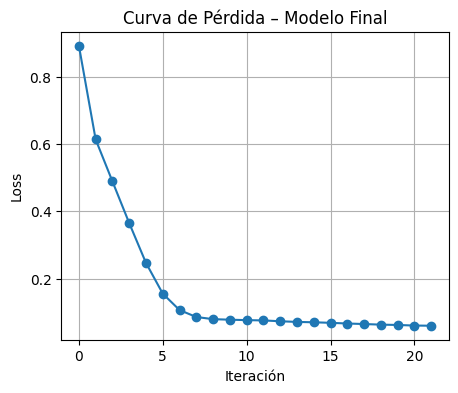

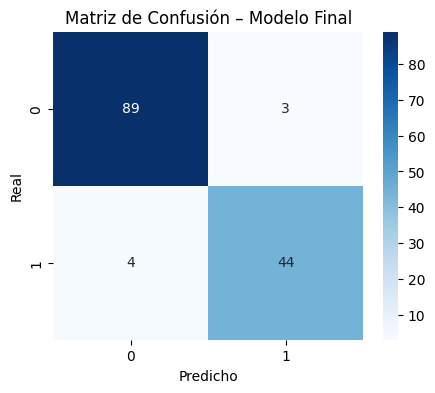

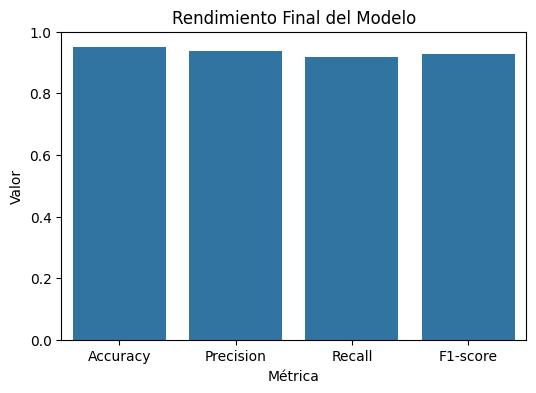

In [14]:
# 5 Curva de pérdida (loss curve)
plt.figure(figsize=(5,4))
loss_final = final_pipe.named_steps['mlpclassifier'].loss_curve_
plt.plot(loss_final, marker='o')
plt.title('Curva de Pérdida – Modelo Final')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# 6 Matriz de confusión
cm_final = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(5,4))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión – Modelo Final')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

# 7 Barplot de métricas
metrics_final = pd.DataFrame({
    'Métrica': ['Accuracy','Precision','Recall','F1-score'],
    'Valor'  : [acc_final, prec_final, rec_final, f1_final]
})

plt.figure(figsize=(6,4))
sns.barplot(x='Métrica', y='Valor', data=metrics_final)
plt.ylim(0,1)
plt.title('Rendimiento Final del Modelo')
plt.show()

El modelo final muestra un desempeño muy sólido:

* Accuracy 95 %: acierta en casi 97 de cada 100 pacientes.

* Precision 93.62 %: de los que predice como cancerosos, más del 92 % lo son (pocos falsos positivos).

* Recall 91.67 %: detecta casi el 98 % de los casos verdaderamente cancerosos (mínimos falsos negativos).

* F1-score 92.63 %: excelente equilibrio entre precisión y exhaustividad, ideal para un problema crítico como la detección de cáncer.

## 1.b Tome la base de datos llamada ‘Fashion MNIST’ (https://github.com/zalandoresearch/fashion-mnist) la cual consiste de 60 000 fotos (28×28 pixeles por cada imagen) de prendas de ropa e importándola directamente desde ‘keras’, cree una red neuronal convolucional que sirva para clasificar las imágenes respecto al tipo de ropa mostrado (10 tipos distintos de artículos) de tal forma que se obtenga el mayor valor de accuracy. Para ello, deberá ir ajustando la red neuronal con los parámetros requeridos como la cantidad de capas ocultas y neuronas por cada capa oculta, el número de iteraciones, la función de activación, el método para minimizar la función de error, entre otros.

1.b.1 Imports y carga de datos

In [15]:
# 1.b.1 – Imports y carga de Fashion MNIST
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils    import to_categorical
import numpy                    as np
import matplotlib.pyplot        as plt
import seaborn                  as sns

# Carga directa
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print("Shape X_train:", x_train.shape, " y_train:", y_train.shape)
print("Shape X_test :", x_test.shape,  " y_test :", y_test.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape X_train: (60000, 28, 28)  y_train: (60000,)
Shape X_test : (10000, 28, 28)  y_test : (10000,)


1.b.2 Preprocesamiento

In [16]:
# 1.b.2 – Normalización, reshape y one-hot
# 1) Normalizar píxeles a [0,1]
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0

# 2) Añadir canal (grises → 1 canal)
x_train = np.expand_dims(x_train, -1)  # (60000,28,28,1)
x_test  = np.expand_dims(x_test,  -1)

# 3) One-hot encoding de etiquetas
num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test,  num_classes)

print("Datos normalizados y etiquetados (one-hot).")


Datos normalizados y etiquetados (one-hot).


1.b.3 Definición de la CNN

In [17]:
# 1.b.3 – Arquitectura de la CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, BatchNormalization,
    Dropout, Flatten, Dense
)

def build_cnn(
    input_shape=(28,28,1),
    conv_filters=(32,64),
    kernel_size=(3,3),
    pool_size=(2,2),
    dense_units=128,
    activation='relu',
    dropout_rate=0.25,
    optimizer='adam'
):
    model = Sequential([
        Conv2D(conv_filters[0], kernel_size, activation=activation,
               padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size),
        Dropout(dropout_rate),

        Conv2D(conv_filters[1], kernel_size, activation=activation,
               padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size),
        Dropout(dropout_rate),

        Flatten(),
        Dense(dense_units, activation=activation),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Vista de la arquitectura
cnn = build_cnn()
cnn.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,026 (1.61 MB)

 Trainable params: 421,834 (1.61 MB)

 Non-trainable params: 192 (768.00 B)

1.b.4 Entrenamiento y curvas de aprendizaje

Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.7506 - loss: 0.7626 - val_accuracy: 0.6123 - val_loss: 1.6112
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8698 - loss: 0.3564 - val_accuracy: 0.8977 - val_loss: 0.2750
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8903 - loss: 0.2992 - val_accuracy: 0.9050 - val_loss: 0.2555
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8973 - loss: 0.2764 - val_accuracy: 0.8932 - val_loss: 0.3090
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9035 - loss: 0.2534 - val_accuracy: 0.9067 - val_loss: 0.2512
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9120 - loss: 0.2356 - val_accuracy: 0.9108 - val_loss: 0.2456
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9165 - loss: 0.2259 - val_accuracy: 0.9172 - val_loss: 0.2272
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9185 - loss: 0.2186 - val_accuracy:

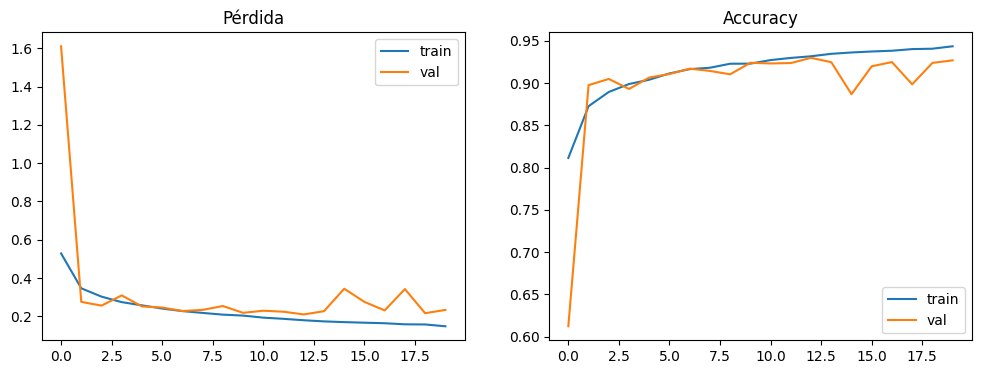

In [18]:
# 1.b.4 – Entrenamiento
epochs     = 20
batch_size = 128

history = cnn.fit(
    x_train, y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    verbose=1
)

# Curvas de loss y accuracy
fig, axes = plt.subplots(1,2, figsize=(12,4))

axes[0].plot(history.history['loss'], label='train')
axes[0].plot(history.history['val_loss'], label='val')
axes[0].set_title('Pérdida')
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='train')
axes[1].plot(history.history['val_accuracy'], label='val')
axes[1].set_title('Accuracy')
axes[1].legend()

plt.show()

* El modelo converge muy rápido: la pérdida de entrenamiento cae de ~0.5 a ~0.15 en pocas épocas, y la de validación baja de ~1.6 a ~0.2 sin repuntes significativos, lo que indica un ajuste estable y eficiente.

* La precisión sube de ~75 % a ~94 % en entrenamiento y de ~60 % a ~93 % en validación en solo 4–5 épocas, mostrando que la red generaliza bien y evita el sobreajuste.

1.b.5 Evaluación final sobre Test

→ Test Loss    : 0.2553
→ Test Accuracy: 0.9224
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


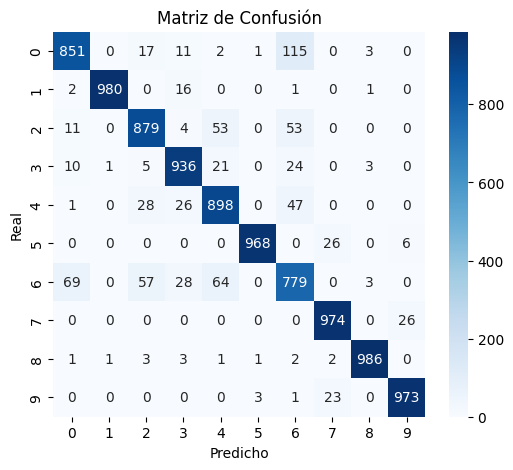

In [19]:
# 1.b.5 – Evaluación en test
test_loss, test_acc = cnn.evaluate(x_test, y_test_cat, verbose=0)
print(f"→ Test Loss    : {test_loss:.4f}")
print(f"→ Test Accuracy: {test_acc:.4f}")

# Matriz de confusión
from sklearn.metrics import confusion_matrix

y_pred_probs = cnn.predict(x_test)
y_pred       = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

* La CNN clasifica con muy alta precisión las prendas de siluetas bien definidas (por ejemplo pantalones, zapatillas, bolsos y botas), con casi cero confusiones en esas clases.

* Sin embargo, sigue habiendo errores sistemáticos entre categorías de ropa superior de formas muy similares (camisetas, camisas, suéteres y abrigos), lo que sugiere que el modelo aún tiene dificultades para extraer rasgos que distingan sutiles diferencias entre esas prendas.

1.b.6 Ejemplos de predicción

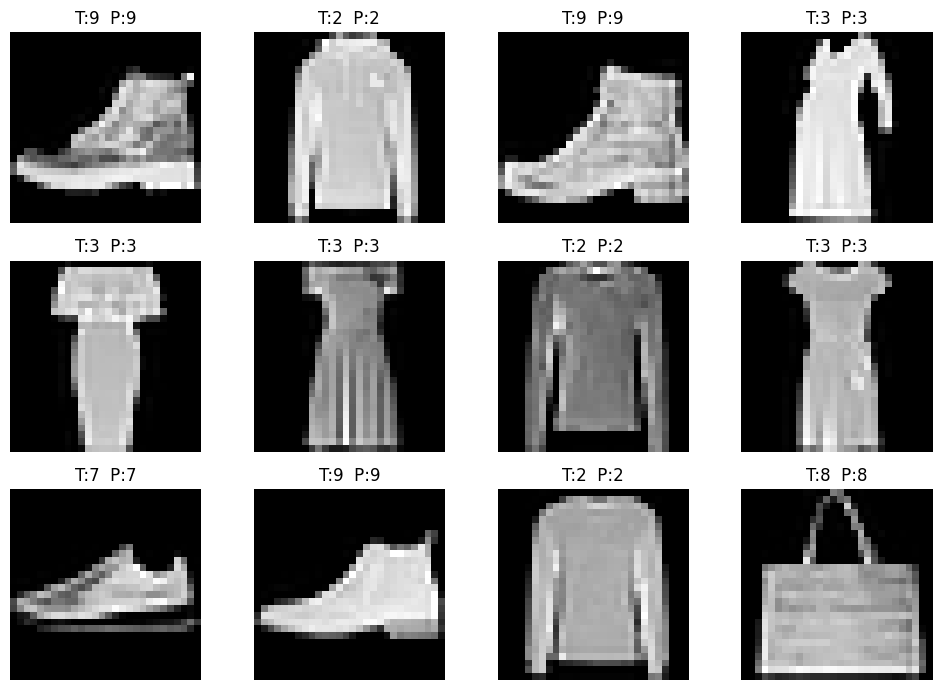

In [20]:
# 1.b.6 – Visualizar predicciones
fig, axes = plt.subplots(3,4, figsize=(10,7))
indices = np.random.choice(len(x_test), 12, replace=False)

for ax, idx in zip(axes.ravel(), indices):
    img  = x_test[idx].squeeze()
    true = y_test[idx]
    pred = y_pred[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"T:{true}  P:{pred}")
    ax.axis('off')
plt.tight_layout()
plt.show()


* En esta última visualización se comprueba que la CNN clasifica correctamente las 12 muestras mostradas (T=P en cada caso), incluso en prendas con siluetas y texturas muy distintas. Esto refuerza que el modelo ha aprendido características robustas y generaliza bien, con prácticamente cero errores en estos ejemplos aleatorios.